# Prepare data for modeling

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import janitor
from pathlib import Path
import re
import plotnine as gg

In [16]:
gg.theme_set(gg.theme_minimal())

In [2]:
data_dir = Path("../data")
save_dir = Path("../modeling_data")

## Cell line information

In [3]:
def show_counts(df, col):
    if type(col) != list:
        col = [col]

    return (
        df[col + ["depmap_id"]]
        .drop_duplicates()
        .groupby(col)
        .count()
        .sort_values("depmap_id", ascending=False)
    )

In [4]:
sample_info = pd.read_csv(save_dir / "sample_info.csv")
show_counts(sample_info, "lineage")

,depmap_id
lineage,
lung,273
blood,132
skin,113
lymphocyte,109
central_nervous_system,107
colorectal,83
breast,82
upper_aerodigestive,76
bone,75


In [5]:
noncancerous_lineages = ["unknown", "embryo"]
engineered_lineages = sample_info[
    sample_info.lineage.str.contains("engineer")
].lineage.to_list()

ignore_lineages = engineered_lineages + noncancerous_lineages
sample_info = sample_info[~sample_info.lineage.isin(ignore_lineages)]

sample_info_columns = [
    "depmap_id",
    "primary_or_metastasis",
    "lineage",
    "lineage_subtype",
]
sample_info = sample_info[sample_info_columns].drop_duplicates()

## *KRAS* mutations

In [6]:
# Remove all cell lines with no mutation data.
all_samples_with_mutation_data = pd.read_csv(
    save_dir / "ccle_mutations.csv"
).depmap_id.unique()

sample_info = sample_info.pipe(
    lambda x: x[x.depmap_id.isin(all_samples_with_mutation_data)]
)

/home/jc604/.conda/envs/speclet/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
kras_mutations = pd.read_csv(save_dir / "kras_mutations.csv")
kras_mutations = kras_mutations[["depmap_id", "kras_mutation"]]

sample_info = sample_info.merge(kras_mutations, on="depmap_id", how="left").assign(
    kras_mutation=lambda x: x.kras_mutation.fillna("WT")
)

In [8]:
sample_info.head()

,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation
0,ACH-000001,Metastasis,ovary,ovary_adenocarcinoma,WT
1,ACH-000002,Primary,blood,AML,WT
2,ACH-000003,NaN,colorectal,colorectal_adenocarcinoma,WT
3,ACH-000004,NaN,blood,AML,WT
4,ACH-000005,NaN,blood,AML,WT


## Screen data

**TESTING WITH ONLY 10,000 ROWS OF DATA.**

In [263]:
achilles_lfc = pd.read_csv(save_dir / "achilles_logfold_change.csv", nrows=10000)
achilles_lfc.head()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True


In [264]:
achilles_guide_map = pd.read_csv(save_dir / "achilles_guide_map.csv")
achilles_guide_map.head()

,sgrna,genome_alignment,n_alignments,hugo_symbol
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,1,SHOC2
1,AAAAAACCCGTAGATAGCCT,chr12_95003615_+,1,NDUFA12
2,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,1,SDAD1
3,AAAAAAGCTCAAGAAGGAGG,chr2_33588446_-,1,FAM98A
4,AAAAAAGGCTGTAAAAGCGT,chr19_19891600_+,1,ZNF253


In [265]:
def print_update_on_dataframe(df, i):
    print("--------")
    print(f"update {i}")
    print(f"data frame shape: {df.shape}")
    print(f"data frame columns:")
    print(df.columns.to_list())
    print("--------")
    print("")


modeling_data = pd.merge(
    left=achilles_lfc, right=sample_info, how="inner", on=["depmap_id"]
)

print_update_on_dataframe(modeling_data, 1)

modeling_data = pd.merge(
    left=modeling_data, right=achilles_guide_map, how="inner", on=["sgrna"]
)

print_update_on_dataframe(modeling_data, 2)

modeling_data.head()

--------
update 1
data frame shape: (10000, 10)
data frame columns:
['sgrna', 'replicate_id', 'lfc', 'depmap_id', 'pdna_batch', 'passes_qc', 'primary_or_metastasis', 'lineage', 'lineage_subtype', 'kras_mutation']
--------

--------
update 2
data frame shape: (9935, 13)
data frame columns:
['sgrna', 'replicate_id', 'lfc', 'depmap_id', 'pdna_batch', 'passes_qc', 'primary_or_metastasis', 'lineage', 'lineage_subtype', 'kras_mutation', 'genome_alignment', 'n_alignments', 'hugo_symbol']
--------



,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,genome_alignment,n_alignments,hugo_symbol
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr10_110964620_+,1,SHOC2
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr12_95003615_+,1,NDUFA12
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr4_75970356_-,1,SDAD1
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr2_33588446_-,1,FAM98A
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr19_19891600_+,1,ZNF253


## Copy number at each guide target

In [266]:
def get_segment_mean(cn_data, depmap_id, chromosome, pos):
    d = cn_data[(cn_data.depmap_id == depmap_id) & (cn_data.chromosome == chromosome)]
    d = d[(d.start <= pos) & (pos <= d.end)]
    if len(d) == 0:
        return None
    elif len(d) > 1:
        raise Exception(f"Data contains more than 1 row of data: {len(d)}")
    else:
        return d.segment_mean.to_list()[0]


def segmentmean_to_copynumber(seg_mean):
    if seg_mean == None:
        return None
    return 2.0 ** seg_mean


def parse_genome_location(gloc):
    d = gloc.split("_")
    d[0] = d[0].replace("chr", "")
    return (d[0], int(d[1]))


cn_segments = pd.read_csv(save_dir / "ccle_semgent_cn.csv")

for i in range(0, len(modeling_data)):
    genome_loc = modeling_data.loc[i, "genome_alignment"]
    depmap_id = modeling_data.loc[i, "depmap_id"]
    g_chr, g_pos = parse_genome_location(genome_loc)

    seg_mean = get_segment_mean(
        cn_data=cn_segments, depmap_id=depmap_id, chromosome=g_chr, pos=g_pos
    )

    modeling_data.at[i, "chromosome"] = g_chr
    modeling_data.at[i, "chr_position"] = g_pos
    modeling_data.at[i, "copy_number"] = segmentmean_to_copynumber(seg_mean)

modeling_data.head(10)

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,genome_alignment,n_alignments,hugo_symbol,chromosome,chr_position,copy_number
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr10_110964620_+,1,SHOC2,10,110964620.0,2.209053
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr12_95003615_+,1,NDUFA12,12,95003615.0,1.846840
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr4_75970356_-,1,SDAD1,4,75970356.0,1.859125
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr2_33588446_-,1,FAM98A,2,33588446.0,2.065029
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr19_19891600_+,1,ZNF253,19,19891600.0,1.833318
5,AAAAAAGGGCTCCAAAAAGG,143b-311cas9_repa_p6_batch3,-0.299879,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr6_26199607_+,1,HIST1H2BF,6,26199607.0,2.122252
6,AAAAACAACACATCAGAGCG,143b-311cas9_repa_p6_batch3,0.083665,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr14_64221554_-,1,SYNE2,14,64221554.0,2.683534
7,AAAAACTCTGGGAAATGACT,143b-311cas9_repa_p6_batch3,0.100364,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr1_229305137_+,1,SPHAR,1,229305137.0,1.823107
8,AAAAAGACAACCTCGCCCTG,143b-311cas9_repa_p6_batch3,0.337476,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr11_64989779_-,1,BATF2,11,64989779.0,1.845355
9,AAAAAGAGCTGTTTGAACAA,143b-311cas9_repa_p6_batch3,0.154017,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,chr1_58689046_-,1,MYSM1,1,58689046.0,2.215645


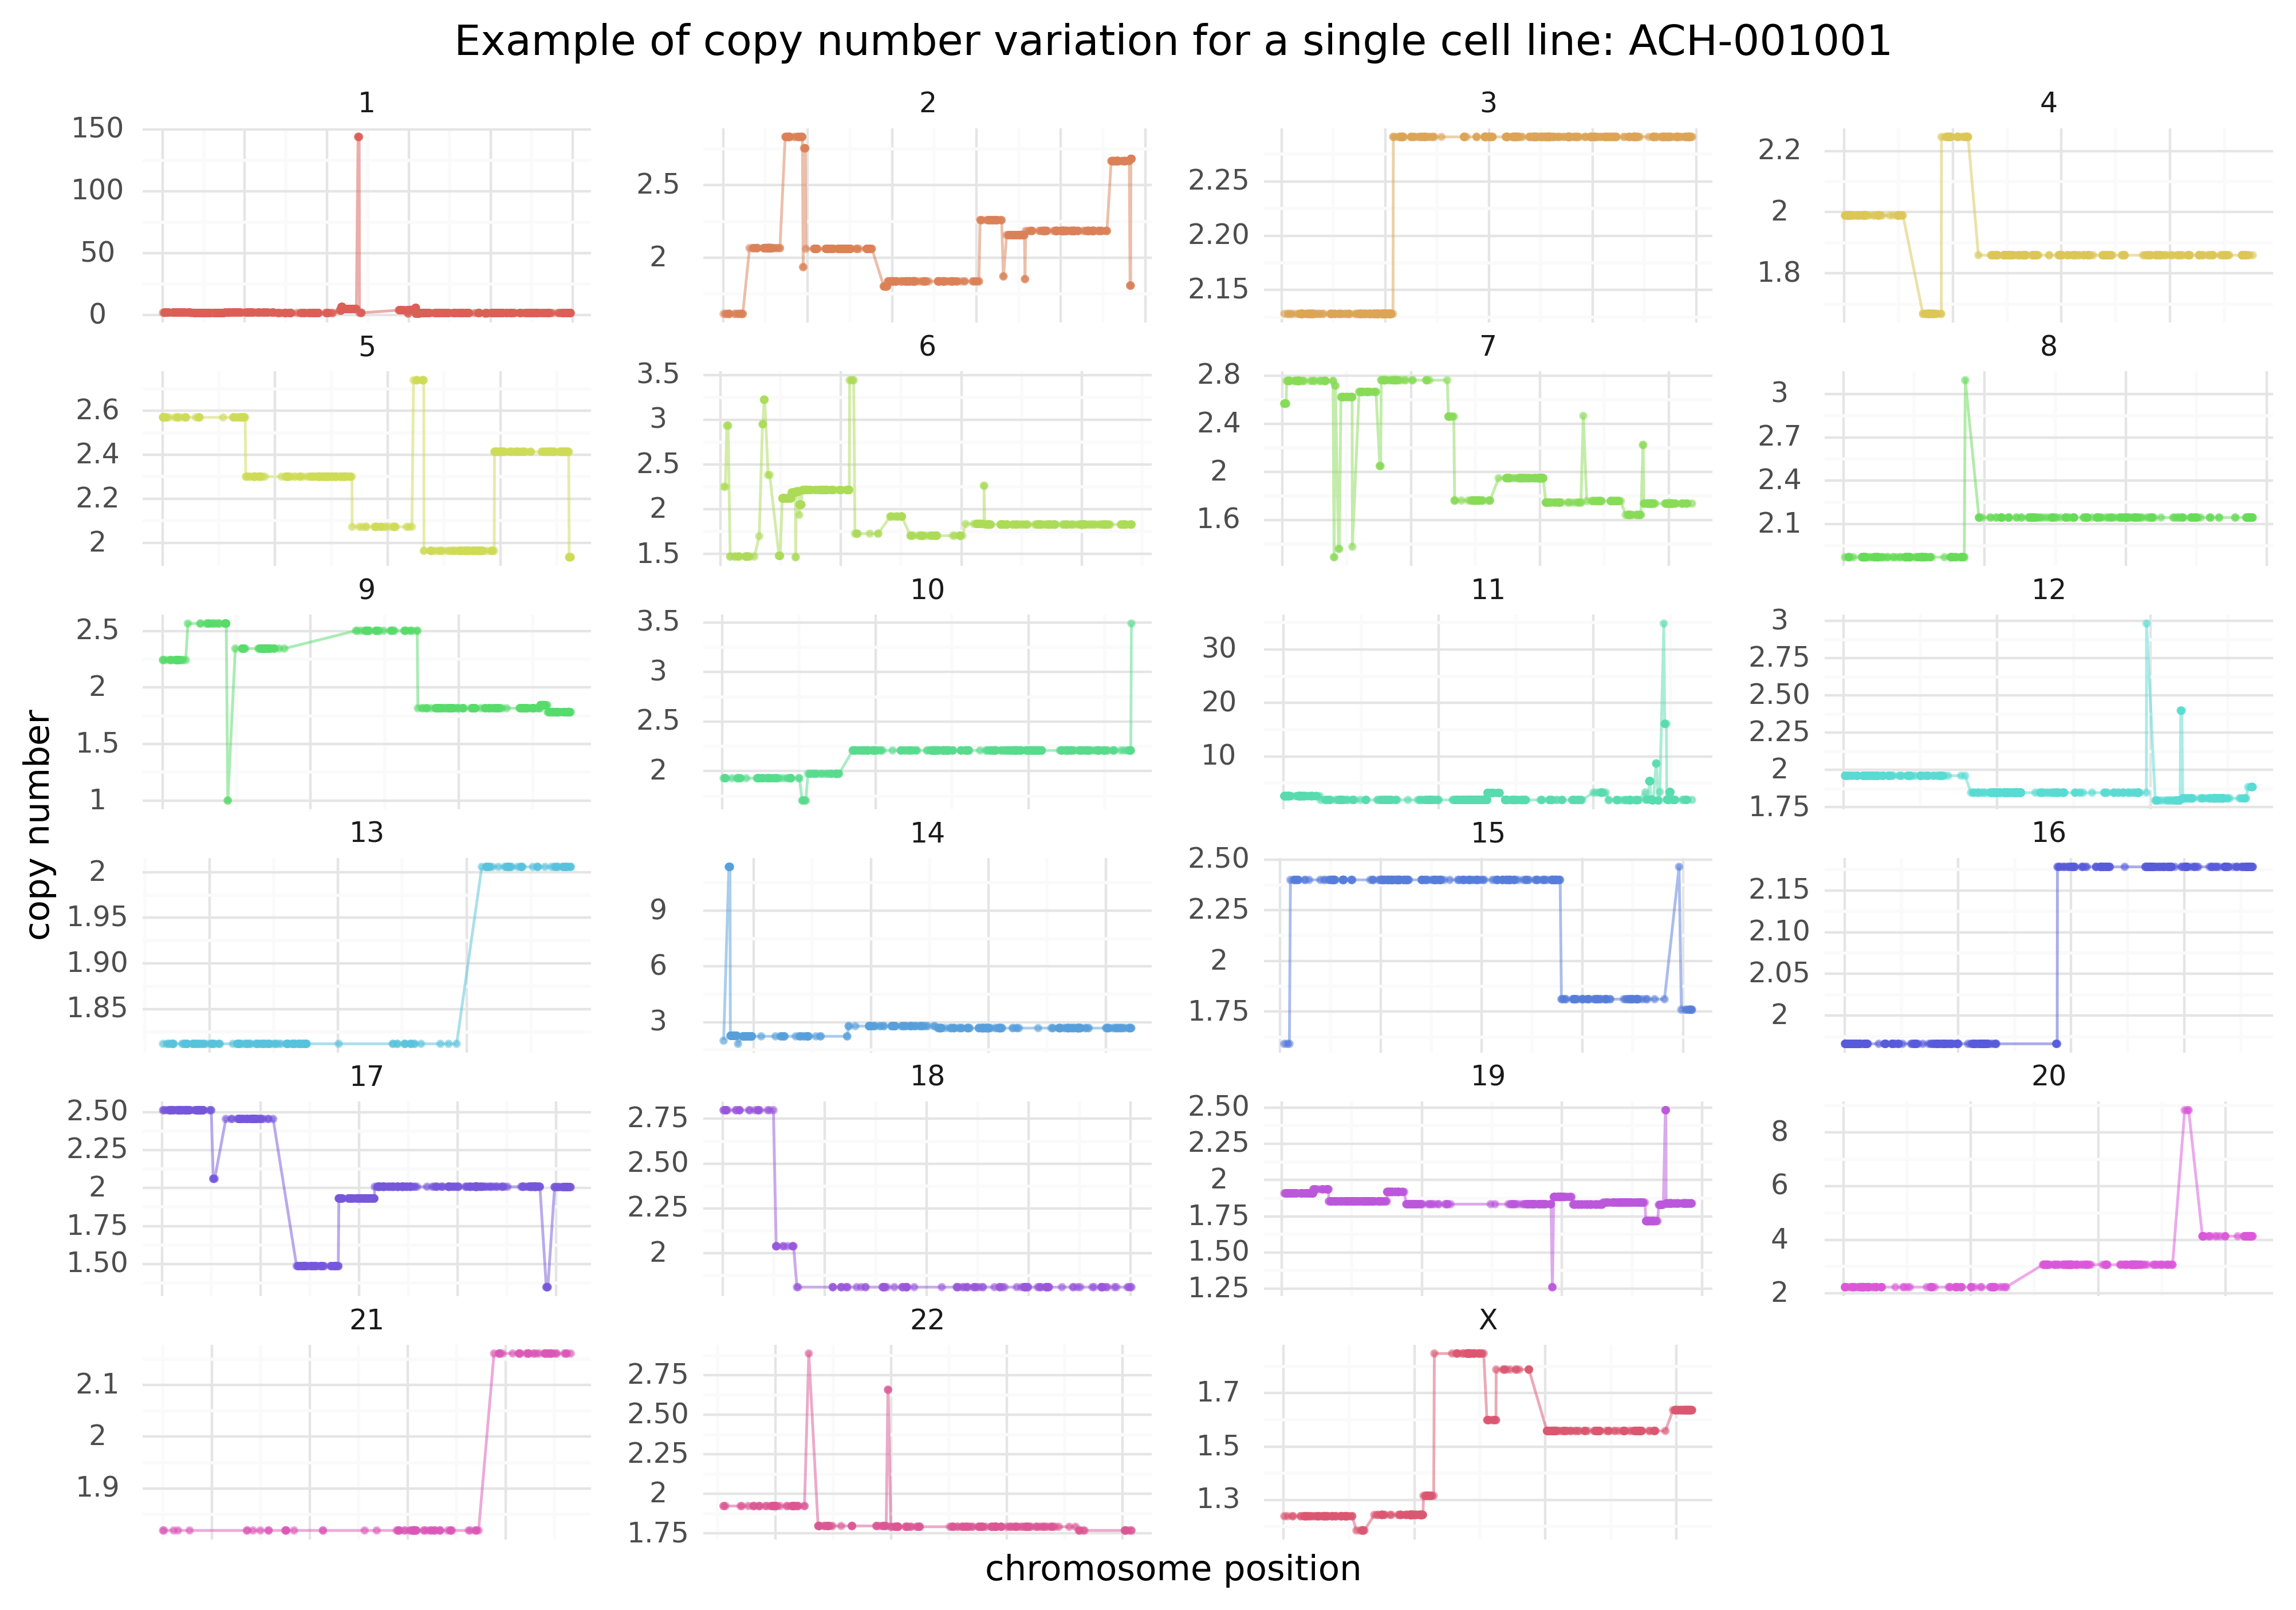

<ggplot: (8731628650165)>

In [267]:
eg_cellline = "ACH-001001"

chromosome_order = [str(a) for a in range(1, 23)] + ["X"]

d = modeling_data[modeling_data.depmap_id == eg_cellline]
d["chromosome"] = pd.Categorical(d.chromosome, categories=chromosome_order)

gg.options.set_option("figure_size", (12, 8))
gg.options.set_option("dpi", 400)

(
    gg.ggplot(d, gg.aes("chr_position", "copy_number", color="chromosome"))
    + gg.facet_wrap("chromosome", ncol=4, scales="free")
    + gg.geom_line(alpha=0.5, size=0.5)
    + gg.geom_point(alpha=0.5, size=0.5)
    + gg.theme_minimal()
    + gg.theme(
        axis_text_x=gg.element_blank(),
        legend_position="none",
        subplots_adjust={"hspace": 0.25, "wspace": 0.25},
        axis_text_y=gg.element_text(hjust=2),
    )
    + gg.labs(
        x="chromosome position",
        y="copy number",
        title=f"Example of copy number variation for a single cell line: {eg_cellline}",
    )
)

## Mutation data of each gene

In [268]:
full_mutations_df = pd.read_csv(save_dir / "ccle_mutations.csv", low_memory=False)

mutations_data_columns = [
    "depmap_id",
    "hugo_symbol",
    "variant_classification",
    "variant_type",
    "isdeleterious",
    "istcgahotspot",
    "iscosmichotspot",
]


def mod_variant_classifications(d):
    d.variant_classification = d.variant_classification.fillna("unknown")
    d.variant_classification = d.variant_classification.astype("str")
    d.variant_classification = [a.lower() for a in d.variant_classification]
    return d


mutations_df = (
    full_mutations_df[mutations_data_columns]
    .rename(
        columns={
            "isdeleterious": "is_deleterious",
            "istcgahotspot": "is_tcga_hotspot",
            "iscosmichotspot": "is_cosmic_hotspot",
        }
    )
    .pipe(mod_variant_classifications)
)


def any_mutations_true(mut_data, col_name):
    return [any([a[col_name] for a in m]) for m in mut_data]


mutations_df = (
    pd.DataFrame(
        mutations_df.set_index(["depmap_id", "hugo_symbol"])
        .apply(lambda d: d.to_dict(), axis=1)
        .groupby(["depmap_id", "hugo_symbol"])
        .agg(mutation_data=lambda x: list(x))
    )
    .assign(n_muts=lambda d: [len(a) for a in d.mutation_data])
    .reset_index()
    .assign(
        any_deleterious=lambda df: any_mutations_true(
            df.mutation_data, "is_deleterious"
        ),
        any_tcga_hotspot=lambda df: any_mutations_true(
            df.mutation_data, "is_tcga_hotspot"
        ),
        any_cosmic_hotspot=lambda df: any_mutations_true(
            df.mutation_data, "is_cosmic_hotspot"
        ),
    )
)

mutations_df.head()

,depmap_id,hugo_symbol,mutation_data,n_muts,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot
0,ACH-000001,AAAS,[{'variant_classification': 'nonsense_mutation...,1,True,False,False
1,ACH-000001,AADACL4,"[{'variant_classification': 'in_frame_del', 'v...",1,False,False,False
2,ACH-000001,ABCC4,[{'variant_classification': 'missense_mutation...,1,False,False,False
3,ACH-000001,AC007431.1,[{'variant_classification': 'missense_mutation...,1,False,False,False
4,ACH-000001,ACOT4,"[{'variant_classification': 'silent', 'variant...",1,False,False,False


Check that there is one row per `depmap_id` x `hugo_symbol` pair.
An error will be raised if this is not true.

In [269]:
x = (
    mutations_df.groupby(["depmap_id", "hugo_symbol"])
    .count()
    .query("mutation_data > 1")
)
if x.shape[0] > 0:
    raise "More than one row per cell line x gene pair"

In [270]:
modeling_data = pd.merge(
    left=modeling_data, right=mutations_df, how="left", on=["depmap_id", "hugo_symbol"]
).fillna(
    value={
        "n_muts": 0,
        "any_deleterious": False,
        "any_tcga_hotspot": False,
        "any_cosmic_hotspot": False,
    }
)

In [271]:
modeling_data.head()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,n_alignments,hugo_symbol,chromosome,chr_position,copy_number,mutation_data,n_muts,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,SHOC2,10,110964620.0,2.209053,NaN,0.0,False,False,False
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,NDUFA12,12,95003615.0,1.846840,NaN,0.0,False,False,False
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,SDAD1,4,75970356.0,1.859125,NaN,0.0,False,False,False
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,FAM98A,2,33588446.0,2.065029,NaN,0.0,False,False,False
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,ZNF253,19,19891600.0,1.833318,NaN,0.0,False,False,False


## A column to indicate if there is a mutation at the guide target location

In [273]:
modeling_data["mutated_at_target"] = False

for i in range(modeling_data.shape[0]):
    g_chr = modeling_data.chromosome[i]
    g_pos = modeling_data.chr_position[i]
    g_depmapid = modeling_data.depmap_id[i]

    mut_d = (
        full_mutations_df.query(f"depmap_id == '{g_depmapid}'")
        .query(f"chromosome == '{g_chr}'")
        .query(f"start_position <= {g_pos} <= end_position")
    )

    if mut_d.shape[0] >= 1:
        modeling_data.loc[i, "mutated_at_target"] = True

In [282]:
modeling_data.groupby("mutated_at_target").count()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,n_alignments,hugo_symbol,chromosome,chr_position,copy_number,mutation_data,n_muts,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot
mutated_at_target,,,,,,,,,,,,,,,,,,,,,
False,9935,9935,9935,9935,9935,9935,9935,9935,9935,9935,...,9935,9935,9935,9935,9935,209,9935,9935,9935,9935


## RNA expression of the target gene

In [285]:
rna_df = pd.read_csv(save_dir / "ccle_expression.csv", nrows=10000).rename(
    columns={"dep_map_id": "depmap_id"}
)
rna_df.head()

,depmap_id,hugo_symbol,rna_expr
0,ACH-001097,TSPAN6,0.000000
1,ACH-001636,TSPAN6,0.000000
2,ACH-001804,TSPAN6,4.934988
3,ACH-000534,TSPAN6,0.839960
4,ACH-001498,TSPAN6,1.744161


In [286]:
modeling_data = pd.merge(
    left=modeling_data, right=rna_df, how="left", on=["depmap_id", "hugo_symbol"]
)

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,chromosome,chr_position,copy_number,mutation_data,n_muts,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,mutated_at_target,rna_expr
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,10,110964620.0,2.209053,NaN,0.0,False,False,False,False,NaN
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,12,95003615.0,1.846840,NaN,0.0,False,False,False,False,NaN
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,4,75970356.0,1.859125,NaN,0.0,False,False,False,False,NaN
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,2,33588446.0,2.065029,NaN,0.0,False,False,False,False,NaN
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,19,19891600.0,1.833318,NaN,0.0,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,AGTCCCGGCCGCCCACCAGG,143b-311cas9_repa_p6_batch3,-0.471124,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,5,132257784.0,1.963801,NaN,0.0,False,False,False,False,NaN
9931,AGTCCCGTGGAAAATGAGGC,143b-311cas9_repa_p6_batch3,-0.232747,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,14,80955684.0,2.683534,NaN,0.0,False,False,False,False,NaN
9932,AGTCCCTAAAAGCCAATGGG,143b-311cas9_repa_p6_batch3,0.480185,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,1,172442375.0,1.821770,NaN,0.0,False,False,False,False,NaN
9933,AGTCCCTCCGAAAATGAAAG,143b-311cas9_repa_p6_batch3,-0.102422,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,2,128017703.0,1.834869,NaN,0.0,False,False,False,False,NaN


---

## Final data frame

In [292]:
modeling_data.head()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,hugo_symbol,chromosome,chr_position,copy_number,mutation_data,n_muts,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,mutated_at_target
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,SHOC2,10,110964620.0,2.209053,NaN,0.0,False,False,False,False
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,NDUFA12,12,95003615.0,1.846840,NaN,0.0,False,False,False,False
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,SDAD1,4,75970356.0,1.859125,NaN,0.0,False,False,False,False
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,FAM98A,2,33588446.0,2.065029,NaN,0.0,False,False,False,False
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True,Primary,bone,osteosarcoma,G12S,...,ZNF253,19,19891600.0,1.833318,NaN,0.0,False,False,False,False


In [293]:
modeling_data.to_csv(save_dir / "dpemap_modeling_dataframe.csv")